In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [4]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
        starter_stage: A boolean indicates whether fire starts at the initializing stage
        neighbor_on_fire: counting neighbors that are on fire
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.starter_stage=model.start_stage
        self.condition = "Fine"
        if model.distribution == 'uniform':
            self.flamebility= np.random.randint(2,50)/100
        elif model.distribution == 'normal':
            self.flamebility = TreeCell.generateNormal(26,13)
        elif model.distribution == 'bimodal':
            self.flamebility = TreeCell.generateBimodal(13,38,6.5)
        elif model.distribution == 'constant':
            self.flamebility=1
        self.neighbor_on_fire=0
        
    '''
        generate normal distribution given mu and sigma
    '''    
    @staticmethod
    def generateNormal(mu,sigma):
        value=np.random.normal(mu,sigma)
        while(value<0 or value>mu*2):
            value=np.random.normal(mu,sigma)
        return value/100
        
    '''
        generate bimodal distribution by combining two normal distributions
    '''
    @staticmethod
    def generateBimodal(mu1,mu2,sigma):
        if np.random.random() > 0.5:
            value=TreeCell.generateNormal(mu1,sigma)
        else:
            value=TreeCell.generateNormal(mu2,sigma)
        return value
        
    
    '''
        change flammability:
        constant: indicates the classic forest fire model.
        if not constant: using the dynamical equation
    '''
    def variate_flamebility(self):
        if(self.model.distribution=="constant"):
            self.flamebility=1
        else:
            self.flamebility=((0.02*self.flamebility)+1)*self.flamebility
        
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        Each 'Fine' tree is attacked by its burning neighbors simultaneously.
        '''
        if self.condition == "On Fire":
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.condition == "Fine":
                    neighbor.neighbor_on_fire+=1
                    if(np.random.random()< (1-(1-neighbor.flamebility)**min(neighbor.neighbor_on_fire,8))):
                        neighbor.condition = "On Fire"
            self.condition = "Burned Out"
        
        elif self.condition == 'Fine' and not self.starter_stage:
            if (np.random.random() < ((1/(90*100)) * self.flamebility)):
                self.condition = 'On Fire'
        self.variate_flamebility()

        # Cap flamebility at 1:
        if (self.flamebility > 1):
            self.flamebility = 1

In [5]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density, env, distr, start_cells,start_stage):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
            distr: flammability distribution. [constant|uniform|normal|bimodal]
            start_cells: fire starts from one border or not
            start_stage: fire only starts at the first step or any steps
        '''
        # Set up model objects
        self.distribution = distr
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")
                                ,"states":lambda m: self.statistics(m,self.anims,self.hist)
                                })
        self.environment=env
        self.time = 0
        self.flamebility_over_time = []
        self.burnt_trees = []
        self.anims=[]
        self.start_cells=start_cells
        self.start_stage=start_stage
        self.hist=[]
        self.sum_flame=[]
        self.mean_flame=[]
        self.agent_count=0
        self.canvas=(height,width)
        # Place a tree in each cell with Prob = density
        for x in range(width):
            for y in range(height):
                if self.random.random() < density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    if(start_cells):
                        if(x==0):
                            new_tree.condition="On Fire"
                    elif(start_stage):
                    # # Some trees can already be on fire in the first step:
                        if(np.random.random()<new_tree.flamebility*(1/90)):         # Changed to 1/90, assuming 90 days for the simulation
                            new_tree.condition="On Fire"

                    self.grid[x][y] = new_tree
                    self.schedule.add(new_tree)
                    self.agent_count+=1
        self.running = True
        self.dc.collect(self)
        # init=np.random.randint(agent_count)
        # self.schedule.agents[init].condition="On Fire"                        # Commented this: The fire can start at a later stage as well in this way
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.burnt_trees.append(self.count_type(self, 'Burned Out'))
        self.flamebility_over_time.append(self.mean_flamebility(self))
        self.schedule.step()
        self.dc.collect(self)
        self.time += 1
        # Halt if no more fire
        if (self.time == 90):
            self.running = False
#         if self.count_type(self, "On Fire") == 0:
#             self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count
    
    @staticmethod
    def mean_flamebility(model):
        '''
        Helper method to count the mean flamebility in the model.
        '''
        flamebility = 0
        nr = 0
        for tree in model.schedule.agents:
            if (tree.condition == 'Fine'):
                flamebility += tree.flamebility
                nr += 1
        if(nr==0):
            return 0
        return flamebility  /nr
    
    @staticmethod
    def statistics(model,frames,hists):
        '''
        Helper method to record intermediate statisticas for visualization
        '''
        image = np.zeros(model.canvas)
        data=[]
        for tree in model.schedule.agents:
            if tree.condition == 'Burned Out':
                image[tree.pos] = 0 
            elif tree.condition == 'Fine':
                image[tree.pos] = 1 
                data.append(tree.flamebility)
            elif tree.condition == 'On Fire':
                image[tree.pos] = 3
        frames.append(image)
        hists.append(data)
        model.mean_flame.append(np.mean(data))
        model.sum_flame.append(np.sum(data))

In [6]:
''' 
simulate for a flammability distribution, generating data for subsequent visualizations
'''
fire = ForestFire(100, 100, 0.70, 0.1, 'uniform', False, False)
fire.run_model()

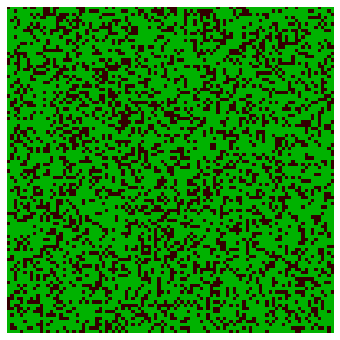

In [7]:
'''
visualization the canvas
'''

from matplotlib import animation
from matplotlib import colors

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_axis_off()
colors_list = [(0.2, 0,0), (0, 0.7, 0), (0.8, 0, 0), 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)
im = ax.imshow(fire.anims[0],cmap=cmap,norm=norm)
def animate(i):
    im.set_data(fire.anims[i])
interval = 10
anim = animation.FuncAnimation(fig, animate, interval=interval, frames = len(fire.anims))
anim.save("tree_animation.gif", writer = 'pillow') #open with web browser


<a list of 98 Patch objects>


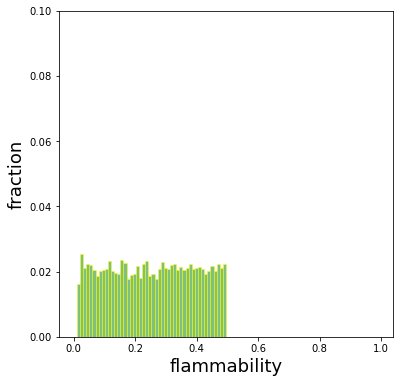

In [8]:
'''
visualization the flammability histogram over steps
'''
HIST_BINS = np.linspace(0, 0.99, 99)
def prepare_animation(bar_container):
    def animate(frame_number):
        # simulate new data coming in
        n, _ = np.histogram(fire.hist[frame_number], HIST_BINS)
        for count, rect in zip(n, bar_container):
            rect.set_height(count/np.sum(n))
        return bar_container
    return animate
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.set_xlabel("flammability",fontsize = 18)
ax.set_ylabel("fraction", fontsize = 18)
_, _, bar_container = ax.hist(fire.hist[0], HIST_BINS,
                              ec = "yellow", fc = "green", alpha=0.5)
print(bar_container)
ax.set_ylim(top = 0.1)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container),interval = 10, frames = len(fire.hist))
ani.save("histogram_animation.gif", writer = 'pillow') #open with web browser

In [ ]:
'''
integrate the mean and total flammability with the canvas
'''
x1_data = list(range(len(fire.mean_flame)))
y1_data = fire.mean_flame
x2_data = list(range(len(fire.sum_flame)))
y2_data = fire.sum_flame
x3_data = list(range(len(fire.sum_flame)))
y3_data = fire.dc.get_model_vars_dataframe()["Burned Out"].values/fire.agent_count
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(18,9))
gs = ax[0, 1].get_gridspec()
for a in ax[0:, -1]:
    a.remove()
axbig = fig.add_subplot(gs[0:, -1])

line1, = ax[0,0].plot(x1_data, y1_data,label = "mean flammability")
line2, = ax[1,0].plot(x2_data, y2_data,label = "sum flammability")
line3, = ax[2,0].plot(x3_data, y3_data,label = "burned out ")
ax[0,0].legend(),ax[1,0].legend(),ax[2,0].legend()
axbig.set_axis_off()
colors_list = [(0.2,0,0), (0,0.7,0), (0.8,0,0), 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)
im = axbig.imshow(fire.anims[0],cmap=cmap,norm=norm)


def update(num, x1, y1, line1,x2,y2,line2, x3,y3,line3,im):
    line1.set_data(x1[:num], y1[:num])
    line1.axes.axis([0, len(x1), 0, max(y1) + 0.1])
    line2.set_data(x2[:num], y2[:num])
    line2.axes.axis([0, len(x2), 0, max(y2) + 100])
    line3.set_data(x3[:num], y3[:num])
    line3.axes.axis([0, len(x3), 0, max(y3) + 0.1])
    im.set_data(fire.anims[num])
    return line1,line2,line3

ani = animation.FuncAnimation(fig, update, len(x1_data), fargs=[x1_data, y1_data, line1,x2_data,y2_data,line2,x3_data,y3_data,line3,im],
                              interval=10, blit=True)
ani.save("integrated_animation.gif", writer='pillow') #open with web browser

<function matplotlib.pyplot.show(*args, **kw)>

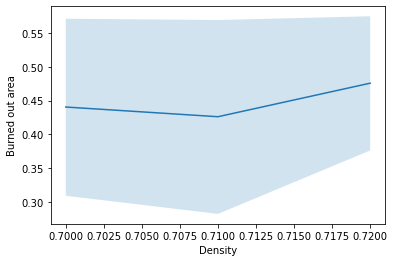

In [12]:
'''
Searching the critical density for each distribution by calculating mean and standard deviation of burned fraction.
'''
burned_out_area = []
burned_out_sd = []
density = []
'''
Searching space is from 0.1 to 0.9 by step size 0.01.
Each parameter is repeated for 10 times to calculate error.

For rapid assessment, set the parameter range to [0.2, 0.22]
'''
for n in np.arange(0.2, 0.22, 0.01 ):
    burns = []
    for r in range(10):
        fire = ForestFire(100, 100, n ,0.1, "uniform", False, False)  #constant, uniform, normal, bimodal
        fire.run_model()
        nr_burns = fire.dc.get_model_vars_dataframe().iloc[-1, 2]
        burns.append(nr_burns)
    burned_out_area.append(np.mean(np.array(burns)/10000))
    burned_out_sd.append(np.std(np.array(burns)/10000))
    density.append(n)

burned_out_area = np.array(burned_out_area)
burned_out_sd = np.array(burned_out_sd)
plt.plot(density, burned_out_area )
plt.fill_between(density, burned_out_area-1.96*burned_out_sd, burned_out_area+1.95*burned_out_sd, alpha=0.2)
plt.ylabel("Burned out area")
plt.xlabel("Density")
plt.show

In [ ]:
'''
Dynamics of flammability function
'''
a = 0.02
b = 0.05
c = 0.10
d = 0.20
e = 0.30
f = 0.50
g = 0.70
h = 0.60
j = 0.40
aa = [a]
bb = [b]
cc = [c]
dd = [d]
ee = [e]
ff = [f]
gg = [g]
hh = [h]
jj = [j]

def change(x):
    x = ((0.02*x)+1) * x
    return x

for i in range(90):
    a = change(a)
    aa.append(a)
    b = change(b)
    bb.append(b)
    c = change(c)
    cc.append(c)
    d = change(d)
    dd.append(d)
    e = change(e)
    ee.append(e)
    f = change(f)
    ff.append(f)
    g = change(g)
    gg.append(g)
    h = change(h)
    hh.append(h)
    j = change(j)
    jj.append(j)

fig = plt.figure(figsize=(15,10))
plt.plot(aa, label=0.02)
plt.plot(bb, label=0.05)
plt.plot(cc, label=0.10)
plt.plot(dd, label=0.20)
plt.plot(ee, label=0.30)
plt.plot(jj, label=0.40)
plt.plot(ff, label=0.50)
plt.plot(hh, label=0.60)
plt.plot(gg, label=0.70)
plt.ylim(0,1)
plt.hlines(y=1, xmin=0, xmax=90, linestyles='dashed')
plt.legend()
plt.title('Change in flammability over time for different initial values')
plt.xlabel('Timestep')
plt.ylabel('Flammability')
plt.show()